<a href="https://colab.research.google.com/github/abhinag007/Stock-Money-MLM/blob/master/CNN_STOCK_PREDICTION_USING_IMAGES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install xgboost

In [ ]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader as pdr

def scale_list(l, to_min, to_max):
    def scale_number(unscaled, to_min, to_max, from_min, from_max):
        return (to_max-to_min)*(unscaled-from_min)/(from_max-from_min)+to_min

    if len(set(l)) == 1:
        return [np.floor((to_max + to_min)/2)] * len(l)
    else:
        return [scale_number(i, to_min, to_max, min(l), max(l)) for i in l]
 

STOCKS = ['AAPL','AXP','BA','CAT','CSCO','CVX','DIS','GE','GS','HD','IBM','INTC','JNJ','JPM','KO','MCD','MMM','MRK','MSFT','NKE','PFE','PG','TRV','UNH','UTX','V','VZ','WMT','XOM']
TIME_RANGE = 20
PRICE_RANGE = 20
VALIDTAION_CUTOFF_DATE = datetime.date(2017, 7, 1)

# split image horizontally into two sections - top and bottom sections
half_scale_size = int(PRICE_RANGE/2)
 
live_symbols = []
x_live = None
x_train = None
x_valid = None
y_train = []
y_valid = []

# xgboost lists
live_data_xgboost = []
validation_data_xgboost = []
train_data_xgboost = []

for stock in STOCKS:
    print(stock)

    # build image data for this stock
    # stock_data = pdr.get_data_google(stock)

    # download dataframe
    stock_data = pdr.get_data_yahoo(stock, start="2000-01-01", end="2018-08-15")

    stock_data['Symbol'] = stock
    stock_data['Date'] = stock_data.index
    stock_data['Date'] = pd.to_datetime(stock_data['Date'], infer_datetime_format=True)
    stock_data['Date'] = stock_data['Date'].dt.date
    stock_data = stock_data.reset_index(drop=True)
 
    # add Moving Averages to all lists and back fill resulting first NAs to last known value
    noise_ma_smoother = 3
    # stock_closes = pd.rolling_mean(stock_data['Close'], window = noise_ma_smoother) 
    stock_closes = stock_data['Close'].rolling(window = noise_ma_smoother).mean()
    stock_closes = stock_closes.fillna(method='bfill')  
    stock_closes =  list(stock_closes.values)
    # stock_opens = pd.rolling_mean(stock_data['Open'], window = noise_ma_smoother)
    stock_opens = stock_data['Open'].rolling(window = noise_ma_smoother).mean()
    stock_opens = stock_opens.fillna(method='bfill')  
    stock_opens =  list(stock_opens.values)
    
    stock_dates = stock_data['Date'].values 
  
    close_minus_open = list(np.array(stock_closes) - np.array(stock_opens))

    # lets add a rolling average as an overlay indicator - back fill the missing
    # first five values with the first available avg price
    longer_ma_smoother = 6
    # stock_closes_rolling_avg = pd.rolling_mean(stock_data['Close'], window = longer_ma_smoother)
    stock_closes_rolling_avg = stock_data['Close'].rolling(window = longer_ma_smoother).mean()
    stock_closes_rolling_avg = stock_closes_rolling_avg.fillna(method='bfill')  
    stock_closes_rolling_avg =  list(stock_closes_rolling_avg.values)

    for cnt in range(4, len(stock_closes)):
        if (cnt % 500 == 0): print(cnt)

        if (cnt >= TIME_RANGE):
            # start making images
            graph_open = list(np.round(scale_list(stock_opens[cnt-TIME_RANGE:cnt], 0, half_scale_size-1),0))
            graph_close_minus_open = list(np.round(scale_list(close_minus_open[cnt-TIME_RANGE:cnt], 0, half_scale_size-1),0))
            
            # scale both close and close MA toeghertogether
            close_data_together = list(np.round(scale_list(list(stock_closes[cnt-TIME_RANGE:cnt]) + 
                list(stock_closes_rolling_avg[cnt-TIME_RANGE:cnt]), 0, half_scale_size-1),0))
            graph_close = close_data_together[0:PRICE_RANGE]
            graph_close_ma = close_data_together[PRICE_RANGE:] 

            outcome = None
            if (cnt < len(stock_closes) -1):
                outcome = 0
                if stock_closes[cnt+1] > stock_closes_rolling_avg[cnt+1]:
                    outcome = 1

            blank_matrix_close = np.zeros(shape=(half_scale_size, TIME_RANGE))
            x_ind = 0
            for ma, c in zip(graph_close_ma, graph_close):
                blank_matrix_close[int(ma), x_ind] = 1 
                blank_matrix_close[int(c), x_ind] = 2  
                x_ind += 1

            # flip x scale dollars so high number is atop, low number at bottom - cosmetic, humans only
            blank_matrix_close = blank_matrix_close[::-1]

            # store image data into matrix DATA_SIZE*DATA_SIZE
            blank_matrix_diff = np.zeros(shape=(half_scale_size, TIME_RANGE))
            x_ind = 0
            for v in graph_close_minus_open:
                blank_matrix_diff[int(v), x_ind] = 3  
                x_ind += 1
            # flip x scale so high number is atop, low number at bottom - cosmetic, humans only
            blank_matrix_diff = blank_matrix_diff[::-1]

            blank_matrix = np.vstack([blank_matrix_close, blank_matrix_diff]) 

            if 1==2:
                # graphed on matrix
                plt.imshow(blank_matrix)
                plt.show()

                # straight timeseries 
                plt.plot(graph_close, color='black')
                plt.show()

            if (outcome == None):
                # live data
                if x_live is None:
                    x_live =[blank_matrix]
                else:
                    x_live = np.vstack([x_live, [blank_matrix]])
                live_symbols.append(stock)

                live_data_xgboost.append(graph_close_ma + graph_close + graph_close_minus_open + [0])

            elif (stock_dates[cnt] >= VALIDTAION_CUTOFF_DATE):
                # validation data
                if x_valid is None:
                    x_valid = [blank_matrix]
                else:
                    x_valid = np.vstack([x_valid, [blank_matrix]])
                y_valid.append(outcome)

                validation_data_xgboost.append(graph_close_ma + graph_close + graph_close_minus_open + [outcome])

            else:
                # training data
                if x_train is None:
                    x_train = [blank_matrix]
                else:
                    x_train = np.vstack([x_train, [blank_matrix]])
                y_train.append(outcome)

                train_data_xgboost.append(graph_close_ma + graph_close + graph_close_minus_open + [outcome])


AAPL
500
1000
1500
2000
2500
3000
3500
4000
4500
AXP
500
1000
1500
2000
2500
3000
3500
4000
4500
BA
500
1000
1500
2000
2500
3000
3500
4000
4500
CAT
500
1000
1500
2000
2500
3000
3500
4000
4500
CSCO
500
1000
1500
2000
2500
3000
3500
4000
4500
CVX
500
1000
1500
2000
2500
3000
3500
4000
4500
DIS
500
1000
1500
2000
2500
3000
3500
4000
4500
GE
500
1000
1500
2000
2500
3000
3500
4000
4500
GS
500
1000
1500
2000
2500
3000
3500
4000
4500
HD
500
1000
1500
2000
2500
3000
3500
4000
4500
IBM
500
1000
1500
2000
2500
3000
3500
4000
4500
INTC
500
1000
1500
2000
2500
3000
3500
4000
4500
JNJ
500
1000
1500
2000
2500
3000
3500
4000
4500
JPM
500
1000
1500
2000
2500
3000
3500
4000
4500
KO
500
1000
1500
2000
2500
3000
3500
4000
4500
MCD
500
1000
1500
2000
2500
3000
3500
4000
4500
MMM
500
1000
1500
2000
2500
3000
3500
4000
4500
MRK
500
1000
1500
2000
2500
3000
3500
4000
4500
MSFT
500
1000
1500
2000
2500
3000
3500
4000
4500
NKE
500
1000
1500
2000
2500
3000
3500
4000
4500
PFE
500
1000
1500
2000
2500
3000
3500
400

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 1000
num_classes = 2
epochs = 20
 
# input image dimensions
img_rows, img_cols = TIME_RANGE, PRICE_RANGE

# add fake depth channel 
x_train_mod = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_valid = x_valid.reshape(x_valid.shape[0], img_rows, img_cols, 1)
input_shape = (TIME_RANGE, PRICE_RANGE, 1)

x_train_mod = x_train_mod.astype('float32')
x_valid = x_valid.astype('float32')

print('x_train_mod shape:', x_train_mod.shape)
print('x_valid shape:', x_valid.shape)
 
y_train_mod = keras.utils.to_categorical(y_train, num_classes)
y_valid_mod = keras.utils.to_categorical(y_valid, num_classes)

model = Sequential()
model.add(Conv2D(64, (5, 5), input_shape=input_shape, activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(Conv2D(10, (2, 2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

x_train_mod shape: (125015, 20, 20, 1)
x_valid shape: (8178, 20, 20, 1)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 16, 16, 64)        1664      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 32)        18464     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 13, 13, 10)        1290      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 10)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 6, 10)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 360)               0         
________________________________________________

In [ ]:
# ######################## testing
# # https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
# from keras.models import Sequential
# from keras.layers import Conv2D, MaxPooling2D
# from keras.layers import Activation, Dropout, Flatten, Dense
# model = Sequential()
# model.add(Conv2D(64, (3, 3), input_shape=input_shape))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(32, (2, 2)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Flatten())  
# model.add(Dense(64))
# model.add(Activation('relu'))
# model.add(Dropout(0.5))
# model.add(Dense(num_classes))
# model.add(Activation('sigmoid'))

# model.compile(loss='binary_crossentropy',
#               optimizer='rmsprop',
#               metrics=['accuracy'])

# model.summary()

In [ ]:
model.fit(x_train_mod, y_train_mod,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_train_mod, y_train_mod))
 

score = model.evaluate(x_train_mod, y_train_mod, verbose=0)
# print('Test loss:', score[0])
# print('Test accuracy:', score[1])
 
predictions_cnn = model.predict(x_valid)

# run an accuracy or auc test
from sklearn.metrics import roc_curve, auc, accuracy_score
 
# balance
print('Outcome balance %f' % np.mean(y_train_mod[:,1]))

# print('Model accuracy: ', accuracy_score(y_valid_mod[:,1], temp_predictions,'%'))
fpr, tpr, thresholds = roc_curve(y_valid_mod[:,1], predictions_cnn[:,1])
roc_auc = auc(fpr, tpr)
print('AUC: %f' % roc_auc)

Epoch 1/20
126/126 [==============================] - 5s 44ms/step - loss: 0.6682 - accuracy: 0.5817 - val_loss: 0.6421 - val_accuracy: 0.6216
Epoch 2/20
126/126 [==============================] - 5s 42ms/step - loss: 0.6348 - accuracy: 0.6341 - val_loss: 0.6147 - val_accuracy: 0.6547
Epoch 3/20
126/126 [==============================] - 5s 42ms/step - loss: 0.6175 - accuracy: 0.6535 - val_loss: 0.6141 - val_accuracy: 0.6545
Epoch 4/20
126/126 [==============================] - 5s 41ms/step - loss: 0.6090 - accuracy: 0.6621 - val_loss: 0.5932 - val_accuracy: 0.6778
Epoch 5/20
126/126 [==============================] - 5s 41ms/step - loss: 0.6001 - accuracy: 0.6691 - val_loss: 0.5873 - val_accuracy: 0.6794
Epoch 6/20
126/126 [==============================] - 5s 41ms/step - loss: 0.5956 - accuracy: 0.6740 - val_loss: 0.5975 - val_accuracy: 0.6704
Epoch 7/20
126/126 [==============================] - 5s 41ms/step - loss: 0.5884 - accuracy: 0.6806 - val_loss: 0.5738 - val_accuracy: 0.6921

In [ ]:

####################################################################
# Play around with thresholds to pick the best predictions
####################################################################

# pick top of class to find best bets 
from sklearn.metrics import roc_auc_score
actuals = y_valid_mod[:,1]
preds = predictions_cnn[:,1]
from sklearn.metrics import accuracy_score
print ('Accuracy on all data:', accuracy_score(actuals,[1 if x >= 0.5 else 0 for x in preds]))
threshold = 0.75
preds = predictions_cnn[:,1][predictions_cnn[:,1] >= threshold]
actuals = y_valid_mod[:,1][predictions_cnn[:,1] >= threshold]
from sklearn.metrics import accuracy_score
print ('Accuracy on higher threshold:', accuracy_score(actuals,[1 if x > 0.5 else 0 for x in preds]))
print('Returns:',len(actuals))


Accuracy on all data: 0.6524822695035462
Accuracy on higher threshold: 0.8469251336898396
Returns: 1496


In [ ]:

####################################################################
# XGBoost
####################################################################

train_xgboost = pd.DataFrame(train_data_xgboost)
val_xgboost = pd.DataFrame(validation_data_xgboost)

outcome = 60
features = [x for x in range(0,60)]

import xgboost as xgb
dtrain = xgb.DMatrix(data=train_xgboost[features],
  label = train_xgboost[[outcome]])
dval = xgb.DMatrix(data=val_xgboost[features],
  label = val_xgboost[[outcome]])

evals = [(dval,'eval'), (dtrain,'train')]

param = {'max_depth': 4, 
       'eta':0.01, 'silent':1, 
       'eval_metric':'auc',
       'subsample': 0.7,
       'colsample_bytree': 0.8,
       'objective':'binary:logistic' }

model_xgb = xgb.train ( params = param,
              dtrain = dtrain,
              num_boost_round = 1000,
              verbose_eval=10, 
              early_stopping_rounds = 100,
              evals=evals,
              maximize = True)

[0]	eval-auc:0.79406	train-auc:0.803119
Multiple eval metrics have been passed: 'train-auc' will be used for early stopping.

Will train until train-auc hasn't improved in 100 rounds.
[10]	eval-auc:0.808855	train-auc:0.815646
[20]	eval-auc:0.812789	train-auc:0.81906
[30]	eval-auc:0.816133	train-auc:0.822043
[40]	eval-auc:0.816027	train-auc:0.822563
[50]	eval-auc:0.818588	train-auc:0.824583
[60]	eval-auc:0.819328	train-auc:0.825392
[70]	eval-auc:0.820079	train-auc:0.826133
[80]	eval-auc:0.821157	train-auc:0.827099
[90]	eval-auc:0.822348	train-auc:0.828183
[100]	eval-auc:0.823561	train-auc:0.829326
[110]	eval-auc:0.824255	train-auc:0.830136
[120]	eval-auc:0.825232	train-auc:0.831006
[130]	eval-auc:0.825742	train-auc:0.831646
[140]	eval-auc:0.826768	train-auc:0.832624
[150]	eval-auc:0.827604	train-auc:0.833379
[160]	eval-auc:0.828317	train-auc:0.833996
[170]	eval-auc:0.829261	train-auc:0.834787
[180]	eval-auc:0.829915	train-auc:0.835399
[190]	eval-auc:0.830425	train-auc:0.835938
[200]	eva


Model Report
Accuracy : 0.7799
AUC Score (Train): 0.859261
0.8927477017364658


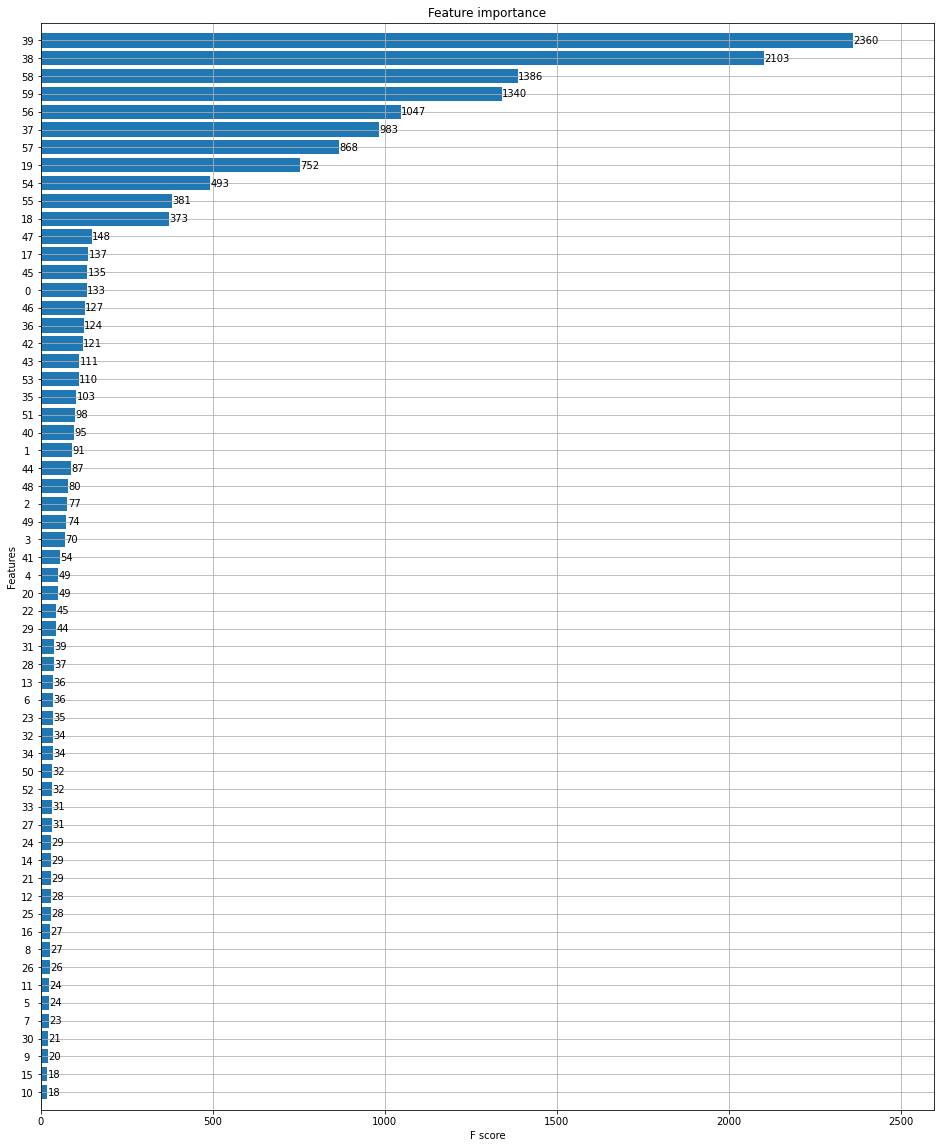

Accuracy : 0.7491
AUC Score (Train): 0.832742


In [ ]:

####################################################################
#Predict training set:
####################################################################

predictions_xgb = model_xgb.predict(dval)
predictions_class = [1 if x >= 0.5 else 0 for x in predictions_xgb]

import sklearn.metrics as metrics
# from sklearn.model_selection import cross_validation    
print ("\nModel Report")
print ("Accuracy : %.4g" % metrics.accuracy_score(val_xgboost[outcome], predictions_class))
print ("AUC Score (Train): %f" % metrics.roc_auc_score(val_xgboost[outcome], predictions_xgb))
best_picks_val = val_xgboost[outcome][predictions_xgb > 0.8]

threshold = 0.7
preds = predictions_xgb[predictions_xgb >= threshold]
actuals = val_xgboost[outcome][predictions_xgb >= threshold]
from sklearn.metrics import accuracy_score
print (accuracy_score(actuals,[1] * len(actuals)))
 
# plot the important features #
fig, ax = plt.subplots(figsize=(16,20))
xgb.plot_importance(model_xgb,  height=0.8, ax=ax)
plt.show()

####################################################################
# Ensembled
####################################################################
ensemble = (predictions_xgb + predictions_cnn[:,1]) / 2
ensemble_class = [1 if x >= 0.5 else 0 for x in ensemble]
print ("Accuracy : %.4g" % metrics.accuracy_score(val_xgboost[outcome], ensemble_class))
print ("AUC Score (Train): %f" % metrics.roc_auc_score(val_xgboost[outcome], ensemble))

In [ ]:
predictions_cnn

array([[0.22944061, 0.77055943],
       [0.21294834, 0.7870517 ],
       [0.15840496, 0.84159505],
       ...,
       [0.34823716, 0.6517629 ],
       [0.4209273 , 0.5790727 ],
       [0.68110746, 0.3188925 ]], dtype=float32)